# Image Captioning with Microsoft COCO Dataset

Students <br>
* Sakshi Singla
* Ivette Sulca

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import nltk
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from pycocotools.coco import COCO
import pickle
import random
import argparse
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import math
from os import listdir
from os.path import join
#! pip install pycocotools

## 1. Resizing Coco Dataset

In [ ]:
crop_size=250
vocab_path = './vocab.pkl'
MAX_LENGTH = 57
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
TRAIN_PATH = Path("./Dataset_coco/train2014")
TRAIN_OUTPATH = Path("./Dataset_coco/n_train2014_2")

VAL_PATH = Path("./val2014/val2014")
VAL_OUTPATH = Path("./Dataset_coco/n_valid2014")

CAPTION_TRAIN_PATH = './Dataset_coco/annotations/captions_train2014.json'
CAPTION_VAL_PATH = './annotations/annotations/captions_val2014.json'

In [6]:
def read_image(path):
    im = mpimg.imread(path) 
    return im

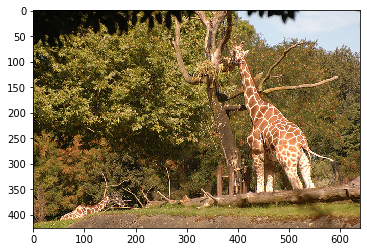

In [7]:
path = TRAIN_PATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im.shape  # R,G,B

(426, 640, 3)

In [9]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(im, (sz, sz))
#     return cv2.resize(center_crop_square(im), (sz, sz))

def resize_all_images(input_path, output_path):
    
    input_path_str = str(input_path)
    for i,f in enumerate(os.listdir(input_path_str)):
       
        if f=='.DS_Store': continue
        
        img = get_a_crop(input_path_str+"/"+f)
        out_path_str = str(output_path) + "/"+f

        cv2.imwrite(out_path_str, img)
        
        if i%10000==0:
            print(f"Processed {i} images")
            print(out_path_str)


In [ ]:
resize_all_images(TRAIN_PATH, TRAIN_OUTPATH)

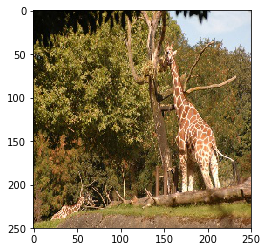

In [11]:
# Reading resized image
path = TRAIN_OUTPATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [12]:
im.shape

(250, 250, 3)

## 2. Creating Dataloaders

In [13]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [14]:
transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [15]:
# Load vocabulary wrapper (created on the other notebook)
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [169]:
class CocoDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None, N=MAX_LENGTH, padding_start=True):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        self.N = N + 2
        self.padding_start = padding_start

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        enc = np.zeros(self.N, dtype=np.int32)
        enc1 = np.array(caption)
        l = min(self.N, len(enc1))
        if self.padding_start:
            enc[:l] = enc1[:l]
        else:
            enc[self.N-l:] = enc1[:l]        

        target = torch.Tensor(enc)
        return image, target

    def __len__(self):
        return len(self.ids)

In [170]:
train_ds = CocoDataset(TRAIN_OUTPATH,CAPTION_TRAIN_PATH,vocab,transform, N=MAX_LENGTH, padding_start=True )

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [172]:
batch_size=10
train_dl = DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True)

In [173]:
len(train_ds)

414113

In [159]:
img, caption = next(iter(train_dl))

In [114]:
img.shape, caption.shape

(torch.Size([100, 3, 250, 250]), torch.Size([100, 59]))

## 3. Model training : Creating encoders and decoders

In [ ]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [36]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]     
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features*4, embed_size) #special resnet
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)

        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
        output = self.out(hidden[-1])
        return output, hidden    

In [42]:
def train_batch(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer,
                teacher_forcing_ratio=0.5):

    encoder.train()
    decoder.train()    
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = y.size(0)
    target_length = y.size(1)
    
    enc_hidden = encoder(x) 
    enc_hidden = enc_hidden.unsqueeze(0) # reshaping 
    
    loss = 0
    dec_input = y[:,0].unsqueeze(1) # allways SOS
    hidden = enc_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(1, target_length):
        output, hidden = decoder(dec_input, hidden)
        yi =  y[:, di]
        if (yi>0).sum() > 0:
            loss += F.cross_entropy(output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        if use_teacher_forcing:
            dec_input = y[:, di].unsqueeze(1)  # Teacher forcing: Feed the target as the next input
        else:                
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [29]:
def save_model(m, p): torch.save(m.state_dict(), p)

def load_model(m, p): m.load_state_dict(torch.load(p))

In [193]:
def train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10,
          teacher_forcing_ratio=0.5):
    
    best_bleu4 = 0 
    predicted_captions_val = []
    best_loss = 10000000000
    for i in range(epochs):
        
        print(f'epoch {i}')
        total_loss = 0
        total_loss_valid = 0
        loss_valid = 0
        total = 0
        total_valid = 0
        
        # One epoch training 
        for x, y in train_dl:
            x = x.float().cuda()
            y = y.long().cuda()
            
            loss = train_batch(x, y, encoder, decoder, enc_optimizer, dec_optimizer,
                               teacher_forcing_ratio)
            total_loss = loss*x.size(0)
            total += x.size(0)
            
        if (total_loss / total)<best_loss:
            best_loss = total_loss / total
            best_path_enc = "./model/model_enc_{0:.4f}.pth".format(best_loss)
            best_path_dec = "./model/model_dec_{0:.4f}.pth".format(best_loss)
            save_model(encoder, best_path_enc)               
            save_model(decoder, best_path_dec)                            

        print("train loss %.3f" % (total_loss / total ))  
    
    return best_path_enc, best_path_dec 

In [194]:
output_size = len(vocab)
hidden_size = 300  #embedding size of the img

encoder = EncoderCNN(hidden_size).cuda()
decoder = DecoderRNN(output_size, hidden_size).cuda()
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001) 

In [195]:
batch_size=500
train_dl = DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True)

In [184]:
len(train_ds)

414113

In [12]:
best_path_enc, best_path_dec = train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10)

epoch 0 
train loss 0.021 
epoch 1 
train loss 0.015 
epoch 2 
train loss 0.015 
epoch 3 
train loss 0.014 
epoch 4 
train loss 0.013 
epoch 5 
train loss 0.013 
epoch 6 
train loss 0.013 
epoch 7 
train loss 0.012 
epoch 8 
train loss 0.012 
epoch 9 
train loss 0.012 



In [197]:
best_path_enc

'./model/model_enc_0.0123.pth'

In [485]:
load_model(decoder, "./model/model_dec_0.0123.pth")
load_model(encoder, "./model/model_enc_0.0123.pth")

## 4. Model evaluation: using BLEU scores

Reference for BLEU-evaluation from NLTK (https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)

In [285]:
transform_val = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [449]:
class CocoValDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None, N=MAX_LENGTH, padding_start=True):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """

        self.root = root
        self.coco = COCO(json)
        dict_val={}
        list_val_keys = self.coco.anns.keys()
        for key in list_val_keys:  
            image_id = self.coco.anns[key]['image_id']
            if image_id in dict_val:
                dict_val[image_id].append(self.coco.anns[key]['caption'])
            else:    
                dict_val[image_id]=[self.coco.anns[key]['caption']] 
        self.dict_val=dict_val        
        self.keys=list(dict_val.keys())
        self.transform = transform
        self.N = N + 2

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        img_id = self.keys[index]
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        captions= self.dict_val[img_id]
        return img_id, image, captions

    def __len__(self):
        return len(self.keys)

In [450]:
val_ds = CocoValDataset(VAL_OUTPATH,CAPTION_VAL_PATH,vocab,transform_val, N=MAX_LENGTH, padding_start=True )
val_dl = DataLoader(dataset=val_ds,batch_size=10)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [433]:
len(val_ds)

40504

In [451]:
x,y,z=next(iter(val_dl))

In [435]:
y.shape

torch.Size([10, 3, 250, 250])

In [468]:
z[0]

['A bicycle replica with a clock as the front wheel.',
 'A black Honda motorcycle parked in front of a garage.',
 'A room with blue walls and a white sink and door.',
 'A car that seems to be parked illegally behind a legally parked car',
 'A large passenger airplane flying through the air.',
 'A bathroom with a toilet, sink, and shower.',
 'A long empty, minimal modern skylit home kitchen.',
 'An office cubicle with four different types of computers.',
 'A bathroom sink with toiletries on the counter.',
 'A small closed toilet in a cramped space.']

In [330]:
def decoding_val(x, encoder, decoder, max_length=MAX_LENGTH+2):
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0
    with torch.no_grad():   
        batch_size = x.size(0)
        hidden = encoder(x) 
        hidden = hidden.unsqueeze(0) # reshaping
        dec_input = SOS_token*torch.ones(batch_size, 1).long().cuda()  # SOS
        decoded_words = []
        
        for di in range(1, max_length):
            output, hidden = decoder(dec_input, hidden)
            pred = output.argmax(dim=1)
            decoded_words.append(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

        return np.transpose(decoded_words)

Predicting captions from validation set

In [ ]:
#MAX_LENGTH #without SOS and END tokens
SOS_token = 1
EOS_token = 2

batch_size=100
valid_dl= DataLoader(dataset=val_ds,batch_size=batch_size)

list_decoded_words = []
list_captions_0 = []
list_captions_1 = []
list_captions_2 = []
list_captions_3 = []
list_captions_4 = []
list_img_id = []
i=0
for img_id, img, captions in valid_dl:
    i+=batch_size
    #print("Processing", i)
    img = img.float().cuda()
    list_decoded_words.extend(decoding_val(img, encoder, decoder))
    list_captions_0.extend(captions[0])
    list_captions_1.extend(captions[1])
    list_captions_2.extend(captions[2])
    list_captions_3.extend(captions[3])
    list_captions_4.extend(captions[4])    
    list_img_id.extend(img_id)

In [487]:
len(list_decoded_words)

40504

In [488]:
len(list_captions_0)

40504

In [ ]:
len(list_img_id)

Calculating BLEU score from validation set

In [493]:
# Model model_dec_0.1080.pth
scores_bleu1 = []
scores_bleu2 = []
scores_bleu3 = []
scores_bleu4 = []
val_size = len(val_ds)
for i in range(val_size):
    #print(i)
    xi = list_decoded_words[i]
    candidate=' '.join([vocab.idx2word[t] for t in xi if t>3])
    references=[list_captions_0[i],list_captions_1[i],list_captions_2[i],list_captions_3[i],list_captions_4[i]]
    #image_id=img_id[i]
    
    scores_bleu1.append(sentence_bleu(references, candidate, weights=(1, 0, 0, 0)))
    scores_bleu2.append(sentence_bleu(references, candidate, weights=(0, 1, 0, 0)))
    scores_bleu3.append(sentence_bleu(references, candidate, weights=(0, 0, 1, 0)))
    scores_bleu4.append(sentence_bleu(references, candidate, weights=(0, 0, 0, 1)))

    if i%10000==0: 
        print("Batch ", i)
print("BLEU-1 score (avg):", np.mean(np.array(scores_bleu1)))
print("BLEU-2 score (avg):", np.mean(np.array(scores_bleu2)))
print("BLEU-3 score (avg):", np.mean(np.array(scores_bleu3)))
print("BLEU-4 score (avg):", np.mean(np.array(scores_bleu4)))

Batch  0
Batch  10000
Batch  20000
Batch  30000
Batch  40000
BLEU-1 score (avg): 0.6096029098588416
BLEU-2 score (avg): 0.35203971444524434
BLEU-3 score (avg): 0.22687861732604692
BLEU-4 score (avg): 0.15477226992626258


## 5. Predicting captions

Testing first image

In [510]:
list_img_id[4]

tensor(106140)

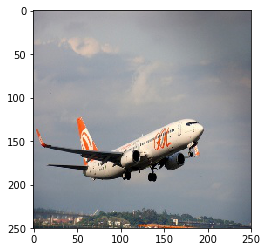

In [511]:
path = VAL_OUTPATH/"COCO_val2014_000000106140.jpg"
im = read_image(path)
plt.imshow(im)

Predicted caption

In [508]:
xi = list_decoded_words[4]
print(' '.join([vocab.idx2word[t] for t in xi if t>3]))

a large airplane is on a runway on a runway . . . .


Real caption

In [509]:
xi = list_captions_0[4]
xi

'A large passenger airplane flying through the air.'

Testing another random image

In [541]:
list_img_id[1309]

tensor(50713)

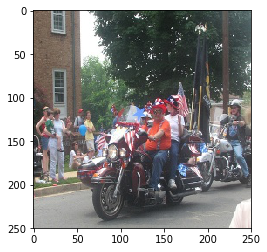

In [542]:
path = VAL_OUTPATH/"COCO_val2014_000000050713.jpg"
im = read_image(path)
plt.imshow(im)

Predicted caption

In [543]:
xi = list_decoded_words[1309]
print(' '.join([vocab.idx2word[t] for t in xi if t>3]))

a group of people are on a motorcycle . . . . . . .


Real caption

In [544]:
xi = list_captions_0[1309]
xi

'A man and woman are riding down the street in a parade wearing patriotic hats.'